In [78]:
from selenium import webdriver 
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.common.by import By 
from selenium.webdriver.chrome.options import Options

from bs4 import BeautifulSoup

# Plotting 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_palette("husl", n_colors=5)  

# Automates downloading and setting up of Chrome Driver
from webdriver_manager.chrome import ChromeDriverManager

import pandas as pd

import re 

import os

In [59]:
# A dict of product categories and product category ID that 
# we shall be scrapping. They will be dynamically inserted on the BASE_URL
PRODUCT_CATEGORIES = {
    "167": "clothes",
    "1": "bags",
    "100000359": "appliances",
    "2381": "home-kitchen",
    "2069": "tvaudiovideo",
    "872": "phones-accessories",
    "482": "health-beauty",
    "38": "watches-jewellery",
    "349": "computers-accessories",
    "1211": "kids-baby-products",
    "100000592": "automotive",

}

# URL for the website.
# product category and web page number will change on demand
BASE_URL = "https://www.kilimall.co.ke/category/{}?id={}&form=category&page={}"

In [60]:
def scrape_page(driver, current_url: str, product_category: str) -> list: 
    """    
    This functions scrapes a single webpage in a paginated website. 

    Args: 
        driver: a webdriver oject
        current_url: the url that will be visited by the driver

    Returns: 
        List of products scraped from a single page/current_url
    """ 

    driver.get(current_url) # Visit the web page 

    # wait for the page to fully load
    wait = WebDriverWait(driver, 4)
    wait.until(EC.presence_of_element_located((By.TAG_NAME, "body"))) 

    html_content = driver.page_source # Access the HTML source 
    
    soup = BeautifulSoup(html_content, "html.parser") # Parse using Beautiful Soup 

    products_wrapper = soup.find_all("div", {"class": "listing-item"}) # Access the products container 

    all_scrapped_products = list()

    # Loop through the products_wrapper to access each product cantainer
    # Then extract the prodcut information 
    for product in products_wrapper:

        product_name = product.find("p", {"class": "product-title"}).text 

        product_price = product.find("div", {"class": "product-price"}).text

        num_reviews = product.find("span", {"class": "reviews"}).text

        product_source = product.find("span", {"class": "tag-name"}).text # Where the product was sourced: Locally or Shipped
        
        # Wrap the produce in a dictionary and append to the list
        scrapped_product_dict = {
            "product_name": product_name,
            "product_price": product_price,
            "number_of_reviews": num_reviews,
            "product_category": product_category,
            "product_source": product_source,
        }
         
        all_scrapped_products.append(scrapped_product_dict) 

    return all_scrapped_products  

In [61]:
def main(BASE_URL: str, num_pages: str): 
    """   
    This is the main function that will be used to scrape the entire website. 

    Args: 
        BASE_URL: The url of the website to be scrapped. Contains the URL that will dynamically change due to pagination and search parameters such as product category 

        num_pages: The number of pages to be scrapped on the specified website.
     
    Returns: 
        A final list containing a dictionary of products scrapped from the entire website
    """ 

    # Set up the use of headless Chrome - No UI 
    chrome_browser_options = Options()
    chrome_browser_options.add_argument("--headless")

    service = Service(ChromeDriverManager().install()) # Set up Chrome driver

    driver = webdriver.Chrome(service=service, options=chrome_browser_options) # Create a webdriver object

    current_page_nummber = 1 # Page Counter. Tracks the current web page being scrapped

    all_products = list() # list of dicts To store the scrapped products

    print("SCRAPPING ACTIVITY STARTED...\n################################\n")

    for category_id, category_name in PRODUCT_CATEGORIES.items(): # Scrapping each product category at a time
        
        print("Scrapping {} Section".format(category_name.capitalize()))

        while current_page_nummber <= num_pages: # Ensure we don't access pages out of range

            current_url = BASE_URL.format(category_name, category_id, current_page_nummber) 

            current_products_sublist = scrape_page(driver, current_url, category_name) 

            all_products.extend(current_products_sublist) # Add this products to the final list of products

            current_page_nummber += 1 # Update the counter to next page

        current_page_nummber = 1 # Reset the count after switching to new product categories

    driver.quit() # Close the driver once done 
    print("\nScrapping Ended")

    return all_products

In [62]:
if __name__ == "__main__":

    # Access all the products scrapped and put them in dataframe
    final_products_list = main(BASE_URL, 2) 
    
    print("\n####___Moving the scrapped products to a dataframe")
    products_df = pd.DataFrame(final_products_list)

    products_df.head()

SCRAPPING ACTIVITY STARTED...
################################

Scrapping Clothes Section
Scrapping Bags Section
Scrapping Appliances Section
Scrapping Home-kitchen Section
Scrapping Tvaudiovideo Section
Scrapping Phones-accessories Section
Scrapping Health-beauty Section
Scrapping Watches-jewellery Section
Scrapping Computers-accessories Section
Scrapping Kids-baby-products Section
Scrapping Automotive Section

Scrapping Ended

####___Moving the scrapped products to a dataframe


In [63]:
# Overview of the dataset
products_df.head()

,product_name,product_price,number_of_reviews,product_category,product_source
0,2pcs/Set Sexy lace Women Nightwear Nightgowns ...,KSh 699,(1646),clothes,Fulfilled By Kilimall
1,SXCHEN New Men's Shorts Casual Sports Five-poi...,KSh 539,(598),clothes,Fulfilled By Kilimall
2,Waist Trainer Slimming Belt Slim Body Shaper C...,KSh 259,(1423),clothes,Fulfilled By Kilimall
3,Waist Trainer Slimming Belt Slim Body Shaper C...,KSh 379,(5777),clothes,Fulfilled By Kilimall
4,2024 Women's Pajamas Satin The Big Size Long ...,KSh 899,(214),clothes,Fulfilled By Kilimall


In [64]:
# create a folder for data storage 
if not os.path.exists("data"):
    os.makedirs("data")

# Store the raw data into a CSV 
products_df.to_csv("data/raw_kilimall_product_data.csv", index=False)

In [65]:
# Doing some data cleaning 

# products_price, number_of_reviews should be formated as ints
# With special characters, whitespaces, and braces removed 
products_df["product_price"] = products_df.product_price.str.replace("Ksh ", "", regex=True, flags=re.IGNORECASE).str.replace(",","").astype("int")

products_df["number_of_reviews"] = products_df.number_of_reviews.str.strip("()").astype("int")

products_df.head()

,product_name,product_price,number_of_reviews,product_category,product_source
0,2pcs/Set Sexy lace Women Nightwear Nightgowns ...,699,1646,clothes,Fulfilled By Kilimall
1,SXCHEN New Men's Shorts Casual Sports Five-poi...,539,598,clothes,Fulfilled By Kilimall
2,Waist Trainer Slimming Belt Slim Body Shaper C...,259,1423,clothes,Fulfilled By Kilimall
3,Waist Trainer Slimming Belt Slim Body Shaper C...,379,5777,clothes,Fulfilled By Kilimall
4,2024 Women's Pajamas Satin The Big Size Long ...,899,214,clothes,Fulfilled By Kilimall


In [66]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   product_name       792 non-null    object
 1   product_price      792 non-null    int64 
 2   number_of_reviews  792 non-null    int64 
 3   product_category   792 non-null    object
 4   product_source     792 non-null    object
dtypes: int64(2), object(3)
memory usage: 31.1+ KB


In [ ]:
# Move the cleaned dataset to a CSV file 
products_df.to_csv("data/cleaned_kilimall_products_data")

Text(0.5, 1.0, 'Average Prices by Product Category')

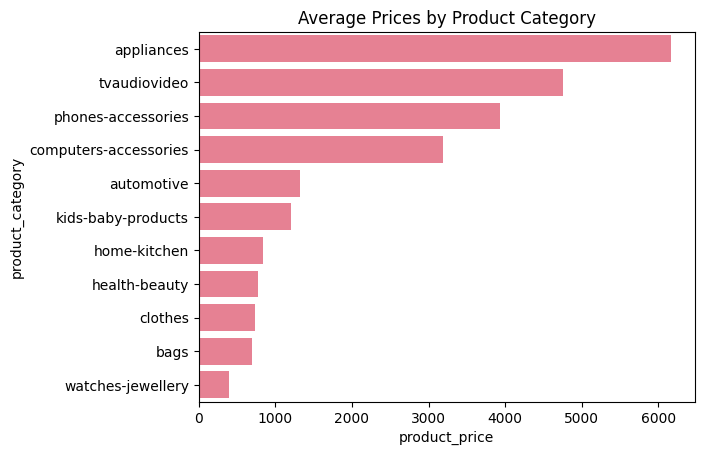

In [77]:
# Simple analysis such as trend, and average 
# prices will also be done as below 

# average prices for each product category 
average_prices_by_category = products_df.groupby("product_category").product_price.mean().reset_index().sort_values("product_price", ascending=False)

sns.barplot(average_prices_by_category, x="product_price", y="product_category")
plt.title("Average Prices by Product Category")